In [45]:
using PETScBinaryIO
using HDF5
using BALUtils
using SparseArrays
using bamg
using Makie
using AbstractPlotting
using Rotations
using RCall
using DataFrames
using Colors
using Statistics
include("../multigrid_analysis/P_to_S.jl")

In [46]:
function readmat(filename, name)
    sz = h5read(filename, "$name/size")
    colptr = h5read(filename, "$name/colptr")
    nzval = h5read(filename, "$name/nzval")
    rowval = h5read(filename, "$name/rowval")
    SparseMatrixCSC(sz..., colptr, rowval, nzval)
end

readmat (generic function with 1 method)

In [53]:
prob = "bal-ladybug-1723"
ba = readbal("../ba-problems/$prob/problem.bal")
iter = 10
f = "../ba-problems/$prob/dump.h5"
A = readmat(f, "$iter/A")
P = readmat(f, "$iter/P_1")

S = p_to_s(P)
@show size(S)
@show size(A)
S_file = "../ba-problems/$prob/S.petsc"
writepetsc(S_file, S)
A_file = "../ba-problems/$prob/A.petsc"
writepetsc(A_file, A)
out_file = "../ba-problems/$prob/sm_eigs.h5"
run(`../multigrid_analysis/build/cr_analysis -A $A_file -S $S_file -out $out_file -eps_minotr -st_type sinvert -eps_target_magnitude -eps_target 0 -eps_converged_reason -eps_nev 100 -eps_max_it 10000`)

size(S) = (15507, 5395)
size(A) = (15507, 15507)
A: 15507 x 15507
S: 15507 x 5395
matrix created
Mat Object: 1 MPI processes
  type: seqaij
  rows=5395, cols=5395
  total: nonzeros=3009619, allocated nonzeros=3009619
  total number of mallocs used during MatSetValues calls =0
    using I-node routines: found 1440 nodes, limit used is 5
 Linear eigensolve converged (121 eigenpairs) due to CONVERGED_TOL; iterations 2
 Linear eigensolve converged (121 eigenpairs) due to CONVERGED_TOL; iterations 2
# converged eigenvalues 121
Eigenvalue 0:  2.2e-05 +  0.0e+00i
Eigenvalue 1:  2.3e-05 +  0.0e+00i
Eigenvalue 2:  2.6e-05 +  0.0e+00i
Eigenvalue 3:  3.0e-05 +  0.0e+00i
Eigenvalue 4:  3.4e-05 +  0.0e+00i
Eigenvalue 5:  3.9e-05 +  0.0e+00i
Eigenvalue 6:  4.2e-05 +  0.0e+00i
Eigenvalue 7:  7.9e-05 +  0.0e+00i
Eigenvalue 8:  9.2e-05 +  0.0e+00i
Eigenvalue 9:  9.8e-05 +  0.0e+00i
Eigenvalue 10:  1.2e-04 +  0.0e+00i
Eigenvalue 11:  1.3e-04 +  0.0e+00i
Eigenvalue 12:  1.4e-04 +  0.0e+00i
Eigenvalue 13:

Process(`../multigrid_analysis/build/cr_analysis -A ../ba-problems/bal-ladybug-1723/A.petsc -S ../ba-problems/bal-ladybug-1723/S.petsc -out ../ba-problems/bal-ladybug-1723/sm_eigs.h5 -eps_minotr -st_type sinvert -eps_target_magnitude -eps_target 0 -eps_converged_reason -eps_nev 100 -eps_max_it 10000`, ProcessExited(0))

In [48]:
function draw_diff!(scene :: Scene, initial :: Array, change :: Array, scale :: Float64; kwargs...)
    moved = initial .+ change * scale
    paired = reshape(vcat(initial, moved), size(initial,1), :)
    linesegments!(scene, paired[1,:], paired[2,:], paired[3,:], transparency=true; kwargs...)
end

draw_diff! (generic function with 1 method)

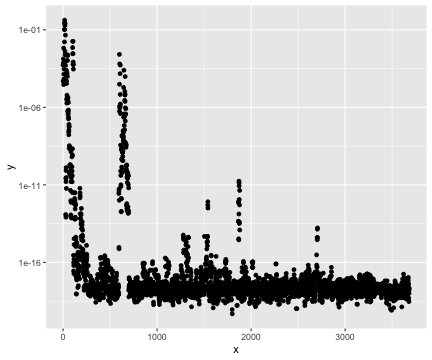

RObject{VecSxp}


┌ Error: Error in renderloop!
│   exception = GLFW.GLFWError(GLFW.PLATFORM_ERROR, "Cocoa: Failed to find service port for display")
└ @ GLMakie /Users/tristan/.julia/packages/GLMakie/tywRm/src/rendering.jl:19
┌ Error: Error in renderloop!
│   exception = GLFW.GLFWError(GLFW.PLATFORM_ERROR, "Cocoa: Failed to find service port for display")
└ @ GLMakie /Users/tristan/.julia/packages/GLMakie/tywRm/src/rendering.jl:24


In [51]:
AbstractPlotting.inline!(false)
eg = reshape(h5read(out_file, "/eigenvector2"), 9, :)
aggs = h5read(f, "0/agg_1")
poses = h5read(f, "$iter/poses")
scale = h5read(f, "$iter/scale")
# TODO: I am not sure if this scaling is correct
eg = eg .* scale

cameras = mapslices(x -> BALUtils.Camera(x), poses, dims=1)
centers = hcat(Vector.(BALUtils.center.(cameras))...)

colors = distinguishable_colors(length(aggs))[aggs]

scene = Scene()

scatter!(scene, centers[1,:], centers[2,:], centers[3,:], transparency=true, markersize=0.5, color=colors)
rotated = zeros(3, size(poses,2))
for i in 1:size(poses,2)
    rotated[:,i] = -(RodriguesVec((poses[1:3,i] + eg[1:3,i])...)' * (poses[4:6,i]+eg[4:6,i])) - centers[:,i]
end
draw_diff!(scene, centers, rotated, 1000.0, transparency=true)
display(scene)
norms = mapslices(x->norm(x), eg, dims=1)

cam = cameracontrols(scene)
cam.near[] = 0.0001

df = DataFrame(x=collect(1:size(eg,2)), y=norms[:])
R"library(ggplot2)"
R"ggplot($df, aes(x=x, y=y)) + geom_point() + scale_y_log10()"

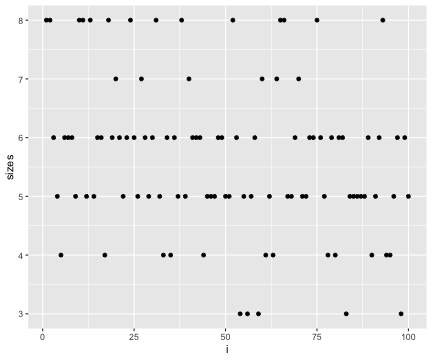

RObject{VecSxp}


In [50]:
szs = map(1:100) do i
    eg = reshape(h5read(out_file, "/eigenvector$i"), 9, :)
    aggs = h5read(f, "0/agg_1")
    scale = h5read(f, "$iter/scale")
    # TODO: I am not sure if this scaling is correct
    eg = eg .* scale
    count(aggs[findmax(mapslices(norm, eg, dims=1)[:])[2]] .== aggs)
end
# TODO: calculate diameter
df = DataFrame(i=1:length(szs), sizes=szs)
display(R"ggplot($df,aes(x=i,y=sizes)) + geom_point()")
#count(map(x -> count(x.==aggs),unique(aggs)) .== 8)